In [1]:
import zCurve as z
import csv
import cv2
import os
import numpy as np
import pandas as pd
import glob
import json 
import matplotlib.pyplot as plt

from ultralytics import YOLO

In [2]:
def calculateMortonFromList_with_zCurve(values):
    # Cap floating point numbers to one decimal place and convert to integers
    int_values = [int(round(value, 1) * 10) for value in values]
    value = z.interlace(*int_values, dims=len(int_values))
    return value 

In [3]:
def overlap(cell_cord, yolo_cord): # [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    x_left = max(cell_cord[0], yolo_cord[0])
    x_right = min(cell_cord[2], yolo_cord[2])
    y_top = max(cell_cord[1], yolo_cord[1])
    y_bottom = min(cell_cord[3], yolo_cord[3])

    if x_right < x_left or y_bottom < y_top:
        return 0, 0, 0, 0, 0
    overlap_area = (x_right - x_left) * (y_bottom - y_top)
    return overlap_area, x_left, y_top, x_right, y_bottom

In [4]:
zod_path = '../datasets/zod_multi_ped/000383/'

In [5]:
config_path = '../config.json'
with open(config_path, 'r') as _f:
    config = json.load(_f)
config['attention_grid']["grid_left_top_coord"]

[[120, 200], [180, 200], [240, 200], [340, 200], [400, 200], [460, 200]]

In [6]:
attention_cells_start_cord = np.array(config['attention_grid']['grid_left_top_coord'])
attention_cell_width = config['attention_grid']['width']
attention_cell_height = config['attention_grid']['height']
attention_cells_end_cord = [start_piont + np.array([attention_cell_width, attention_cell_height]) for start_piont in attention_cells_start_cord]

In [7]:
cell_coord_all = np.concatenate([attention_cells_start_cord, attention_cells_end_cord], axis=1)
cell_coord_all

array([[120, 200, 180, 320],
       [180, 200, 240, 320],
       [240, 200, 300, 320],
       [340, 200, 400, 320],
       [400, 200, 460, 320],
       [460, 200, 520, 320]])

### Test with one image

In [7]:
bgr_resize = cv2.resize(cv2.imread(os.path.join(zod_path, '000150.png')), (640, 480))

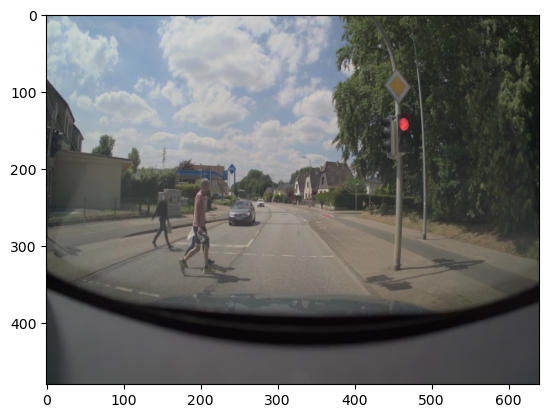

In [11]:
plt.imshow(cv2.cvtColor(bgr_resize, cv2.COLOR_BGR2RGB))

In [12]:
yolo = YOLO("yolo11x.pt")  # load an official model
results = yolo.predict(bgr_resize, verbose=False)

In [51]:
yolo_start_point = []
yolo_end_point = []
for result in results:
    result = result.boxes.cpu().numpy()
    human_cls_index = np.where(result.cls == 0)
    if result.data.size > 0:
        humans_xyxyc = result.data[human_cls_index].astype(np.int64)
        for i in range(len(humans_xyxyc)):
            yolo_start_point.append([humans_xyxyc[i][0], humans_xyxyc[i][1]])
            yolo_end_point.append([humans_xyxyc[i][2], humans_xyxyc[i][3]])
    else:
        yolo_start_point = None
        yolo_end_point = None


In [52]:
yolo_start_point

[[172, 212], [136, 232]]

In [53]:
yolo_end_point

[[217, 336], [166, 304]]

In [54]:
if yolo_start_point is not None and yolo_end_point is not None:
    yolo_coord_all = np.concatenate([yolo_start_point, yolo_end_point], axis=1)
    print(yolo_coord_all)
else: 
    yolo_coord_all = None

[[172 212 217 336]
 [136 232 166 304]]


3024
3996
0
0
0
0


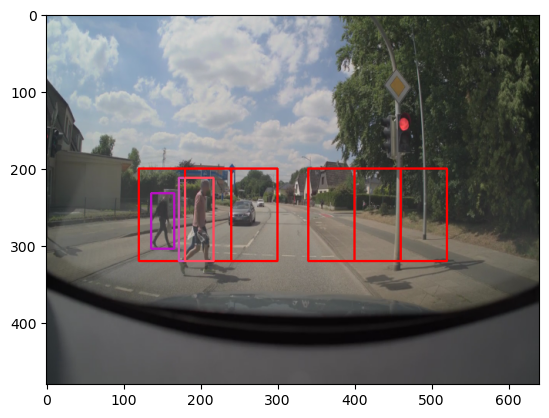

In [69]:
bgr_copy = bgr_resize.copy()
for i in range(len(cell_coord_all)):
    cell_coord = cell_coord_all[i]
    
    cv2.rectangle(bgr_copy, cell_coord[:2], cell_coord[2:], (0,0,255), 2)
    overlap_cum = 0
    #print(i)
    for j in yolo_coord_all:
        overlap_area, x_left, y_top, x_right, y_bottom = overlap(cell_coord, j)
        
        color = list(np.random.random(size=3) * 256)
        cv2.rectangle(bgr_copy, [x_left, y_top], [x_right, y_bottom], color, 2)
        
        overlap_cum += overlap_area
        #print(overlap_area, x_left, y_top, x_right, y_bottom)
    print(overlap_cum)

    #break
plt.imshow(cv2.cvtColor(bgr_copy, cv2.COLOR_BGR2RGB))

In [71]:
input_zcurve = np.zeros(6)
for i in range(len(cell_coord_all)):
    cell_coord = cell_coord_all[i]
    overlap_cum = 0
    for j in yolo_coord_all:
        overlap_area, x_left, y_top, x_right, y_bottom = overlap(cell_coord, j)    
        overlap_cum += overlap_area

    cell_area = config['attention_grid']['width'] * config['attention_grid']['height']
    if overlap_cum > 0:
        input_zcurve[i] = overlap_cum / cell_area
    
    print(overlap_cum, cell_area, x_left, y_top, x_right, y_bottom)
print(input_zcurve)

3024 7200 136 232 166 304
3996 7200 0 0 0 0
0 7200 0 0 0 0
0 7200 0 0 0 0
0 7200 0 0 0 0
0 7200 0 0 0 0
[       0.42       0.555           0           0           0           0]


In [72]:
morton = calculateMortonFromList_with_zCurve(input_zcurve)
morton

12416

### Combine everything to process all images in a sequence. 

In [131]:
morton_codes = []
sfc_input= []
for rgb_frame in sorted(glob.glob(os.path.join(zod_path, '*.png'))):
    yolo_start_point = []
    yolo_end_point = []
    yolo = YOLO("yolo11m.pt") 
    bgr_resize = cv2.resize(cv2.imread(rgb_frame), (640, 480))
    results = yolo.predict(bgr_resize, verbose=False)
    for result in results:
        result = result.boxes.cpu().numpy()
        human_cls_index = np.where(result.cls == 0)
        if result.data[human_cls_index].size > 0:
            humans_xyxyc = result.data[human_cls_index].astype(np.int64)
            for i in range(len(humans_xyxyc)):
                yolo_start_point.append([humans_xyxyc[i][0], humans_xyxyc[i][1]])
                yolo_end_point.append([humans_xyxyc[i][2], humans_xyxyc[i][3]])
        else:
            yolo_start_point = None
            yolo_end_point = None

    if yolo_start_point is not None and yolo_end_point is not None:
        yolo_coord_all = np.concatenate([yolo_start_point, yolo_end_point], axis=1)
    else: 
        yolo_coord_all = None
        
    cell_coord_all = np.concatenate([attention_cells_start_cord, attention_cells_end_cord], axis=1)

    bgr = bgr_resize.copy()

    input_zcurve = np.zeros(6)
    if yolo_coord_all is not None:
        for i in range(len(cell_coord_all)):
            cell_coord = cell_coord_all[i]
            bgr_overlap = cv2.rectangle(bgr, cell_coord[:2], cell_coord[2:], (0,0,255), 2)
            overlap_cum = 0
            for j in yolo_coord_all:
                overlap_area, x_left, y_top, x_right, y_bottom = overlap(cell_coord, j)
                color = list(np.random.random(size=3) * 256)
                bgr_overlap = cv2.rectangle(bgr, [x_left, y_top], [x_right, y_bottom], color, 2)
                overlap_cum += overlap_area
            
            cell_area = config['attention_grid']['width'] * config['attention_grid']['height']
            if overlap_cum > 0:
                input_zcurve[i] = overlap_cum / cell_area
                if input_zcurve[i] >= 1:
                    input_zcurve[i] = 1 
    else:
        for cell_coord in cell_coord_all:
            bgr_overlap = cv2.rectangle(bgr, cell_coord[:2], cell_coord[2:], (0,0,255), 2)
    
    # overlap_path = rgb_frame.replace('datasets/zod_multi_ped', 'outputs/zod_multi_ped')
    # if not os.path.exists(os.path.dirname(overlap_path)):
    #     os.makedirs(os.path.dirname(overlap_path))
    # cv2.imwrite(overlap_path, bgr_overlap)

    sfc_input.append({'frame': rgb_frame, 'cell_0': input_zcurve[0], 'cell_1': input_zcurve[1],
                                             'cell_2': input_zcurve[2], 'cell_3': input_zcurve[3],
                                             'cell_4': input_zcurve[4], 'cell_5': input_zcurve[5]})

    morton_bgr = calculateMortonFromList_with_zCurve(input_zcurve)
    morton_codes.append({'frame': rgb_frame, 'morton': morton_bgr})

morton_codes = pd.DataFrame(morton_codes, columns=['frame', 'morton'])
morton_codes.to_csv('../outputs/yolo_morton_zod_multi_ped.csv', sep=';', index=False)

sfc_input = pd.DataFrame(sfc_input, columns=['frame', 'cell_0', 'cell_1', 'cell_2',
                                                      'cell_3', 'cell_4', 'cell_5'])
sfc_input.to_csv('../outputs/sfc_input_zod_multi_ped.csv', sep=';', index=False)

### Read the saved csv and plot

In [8]:
morton_codes_yolo_proportion = pd.read_csv('../outputs/yolo_morton_zod_multi_ped.csv', sep=';')
morton_codes_yolo_proportion = morton_codes_yolo_proportion.to_numpy()

In [9]:
mortons_seq = []
for i in range(len(morton_codes_yolo_proportion)):
    frame, morton = morton_codes_yolo_proportion[i]
    mortons_seq.append(int(morton))
print(mortons_seq)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 3, 2, 128, 2, 2, 3, 1, 64, 1, 64, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64, 65, 4096, 4096, 4160, 4161, 262208, 262145, 262144, 4224, 528449, 12291, 12416, 8259, 8258, 8258, 8640, 8640, 24640, 16513, 16516, 16774, 16774, 24832, 16512, 388, 16772, 390, 386, 132, 10, 518, 33538, 33036, 33036, 33536, 33536, 33540, 33548, 33540, 33036, 33536, 33048, 33040, 540, 1548, 1544, 1544, 1544, 1536, 1552, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1552, 1552, 1552, 1552]


[128, 4096, 4096, 4160, 4161, 4224, 12291, 12416, 8259, 8258, 8258, 8640, 8640, 24640, 16513, 16516, 16774, 16774, 24832, 16512, 388, 16772, 390, 386, 132, 518, 33538, 33036, 33036, 33536, 33536, 33540, 33548, 33540, 33036, 33536, 33048, 33040, 540, 1548, 1544, 1544, 1544, 1536, 1552, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1552, 1552, 1552, 1552]


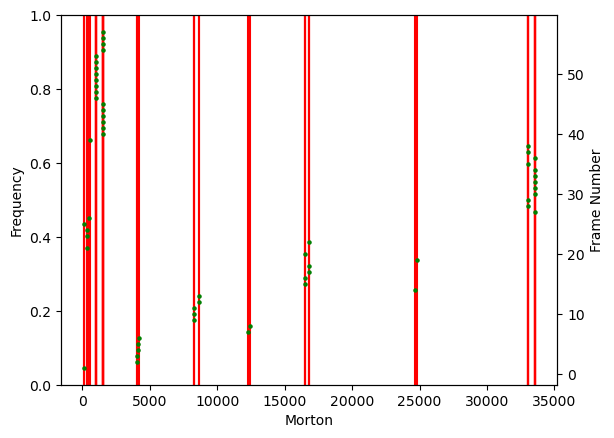

In [12]:
mortons_seq = [i for i in mortons_seq if (i < 50000 and i > 100)]
print(mortons_seq)
fig, ax1 = plt.subplots()
ax1.set_xlabel("Morton")
ax1.set_ylabel("Frequency")
ax1.set_ylim((0, 1))
ax1.eventplot(mortons_seq, orientation='horizontal', colors="red",lineoffsets=0.5)

ax2 = ax1.twinx()
for frame_id in range(len(mortons_seq)):
    x=mortons_seq[frame_id]
    y=frame_id+1
    ax2.scatter(x, y, s=5, color='green')
    ax2.set_ylabel("Frame Number")